In [17]:
import cv2
print(cv2.__version__)

import numpy as np
from matplotlib import pyplot as plt
import time
import math

# # Only for jupyter notebook visualization
# %matplotlib inline 

4.9.0


In [18]:
image = cv2.imread('/home/student/map.png')
image = cv2.flip(image, 0)
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

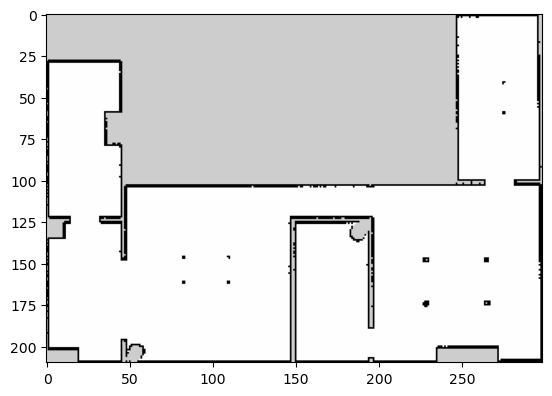

In [19]:
plt.imshow(image_rgb)
plt.show()

In [20]:
R = image_rgb[:,:,0] # Getting the first axis, Red
G = image_rgb[:,:,1] # Getting the second axis, Green
B = image_rgb[:,:,2] # Getting the third axis, Blue

# Each channel can be seen as a grayscale image
print(R.shape, G.shape, B.shape)

(210, 299) (210, 299) (210, 299)


In [21]:
min_value = 250
image_rgb[image_rgb[:,:,0] < min_value] = 0
image_rgb[image_rgb[:,:,1] < min_value] = 0
image_rgb[image_rgb[:,:,2] < min_value] = 0

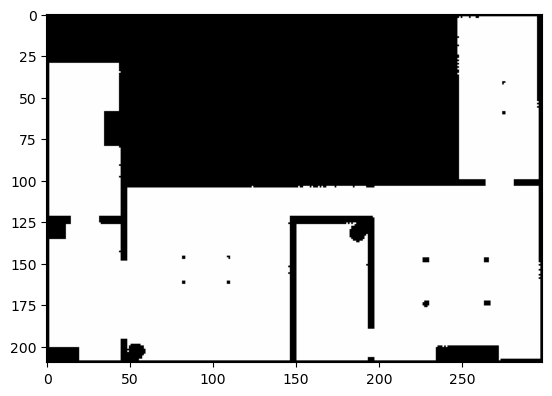

In [22]:
plt.imshow(image_rgb)
plt.show()

In [23]:
cv2.imwrite("/home/student/map_black.png", image_rgb)

True

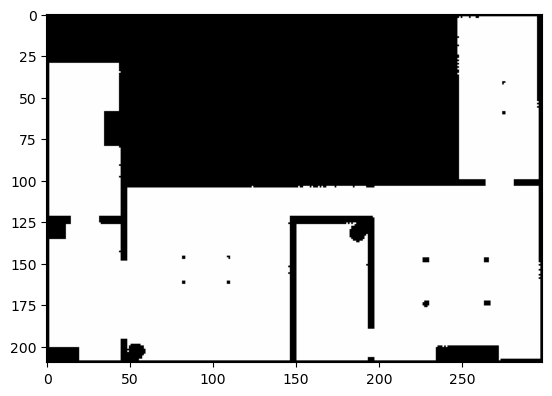

In [24]:
image = cv2.imread('/home/student/map_black.png')
image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.savefig('map_black.png', dpi=300)
plt.show()
# convert the image to grayscale format
img_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)

In [25]:
def room_detection(image,iteration):
# convert the image to grayscale format
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
    if iteration == 1:
        kernel = np.ones((3,3),np.uint8)
   
    if iteration == 2:      # second iteration to spot the corridor
        kernel = np.ones((1,1),np.uint8)
 
    erosion = cv2.erode(img_gray,kernel,iterations = 10)
    dilate = cv2.dilate(erosion,kernel,iterations = 10)
    plt.imshow(dilate, cmap='gray')
    plt.savefig(f'erose_dilate{iteration}.png', dpi=300)
    plt.show()
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=dilate, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # draw contours on the original image
    image_rgb = cv2.cvtColor(dilate,cv2.COLOR_BGR2RGB)
    cv2.drawContours(image=image_rgb, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    plt.imshow(image_rgb)
    plt.savefig(f'contours{iteration}.png', dpi=300)
    plt.show()
    n_rooms = 0
    rooms_array = {}
 
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour) # x,y top-left coordinate of the rectangle and w,h be its width and height
        area = w*h
        if area > 150:
            n_rooms+=1
            image_copy = image.copy()
            cv2.rectangle(image_copy,(x,y),(x+w,y+h),(255,0,0),2)
            plt.imshow(image_copy)
            plt.savefig(f'box{n_rooms}.png', dpi=300)
            plt.show()

            if iteration == 2:
                rooms_array[6] = {'x': x, 'y': y, 'x+w' : x+w, 'y+h' : y+h }
            else:
                rooms_array[n_rooms] = {'x': x, 'y': y, 'x+w' : x+w, 'y+h' : y+h }

    iteration = iteration + 1
    return(rooms_array,iteration)


In [26]:
def apply_mask(image, rooms_dict):
    masked_image = image.copy()
    keys_to_extract = range(1, len(rooms_dict) + 1)
 
    bounding_boxes = np.array([rooms_dict[key] for key in keys_to_extract])
 
    # Extract coordinates as tuples (x, y, x+w, y+h)
    coordinates = [(box['x'], box['y'], box['x+w'], box['y+h']) for box in bounding_boxes]
 
    for box in coordinates:
        x, y, x_plus_w, y_plus_h = box
        for i in range(x, x_plus_w):
            for j in range(y, y_plus_h):
                masked_image[j, i] = (0, 0, 0)
    return(masked_image)

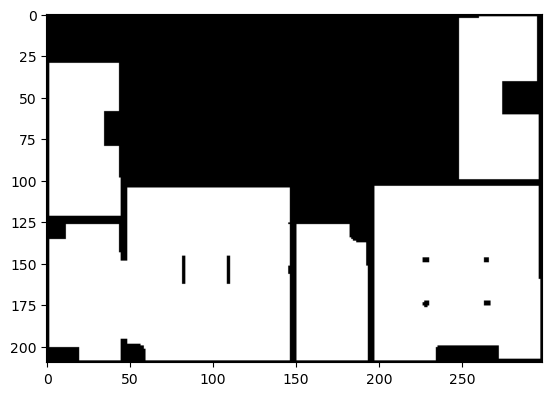

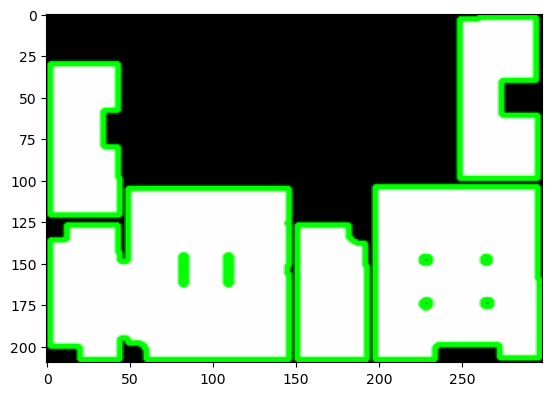

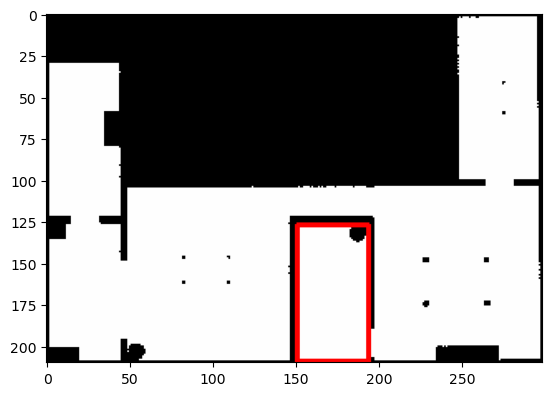

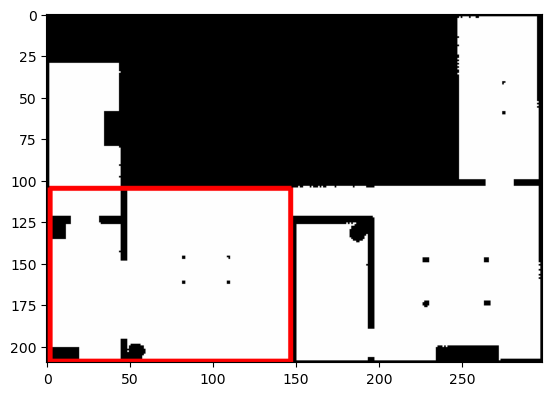

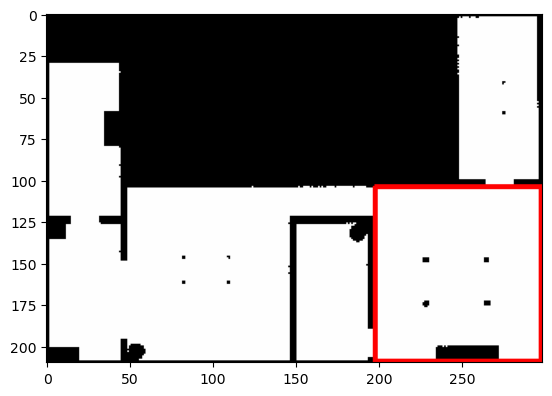

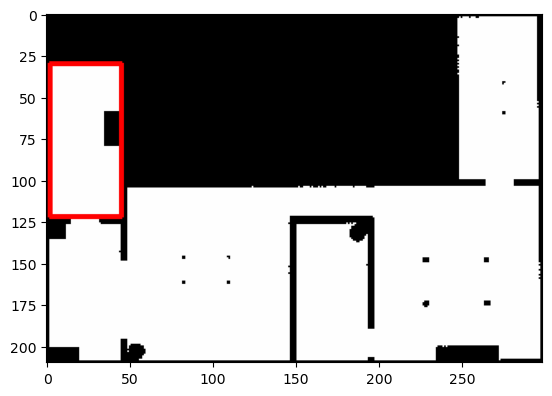

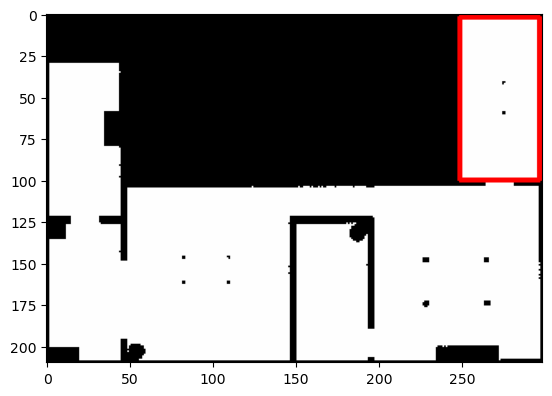

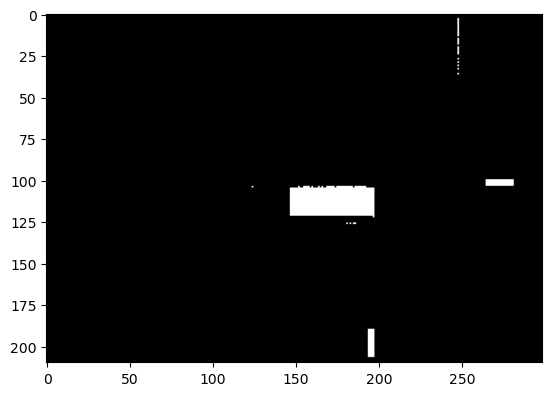

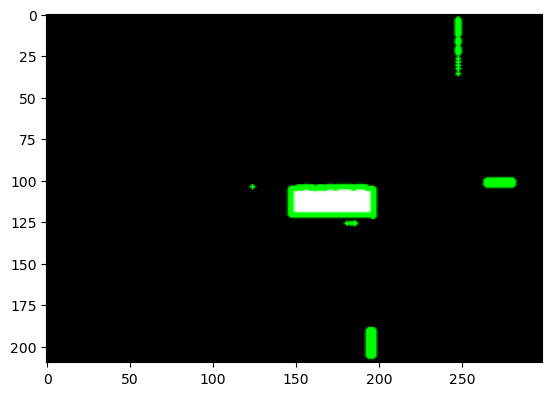

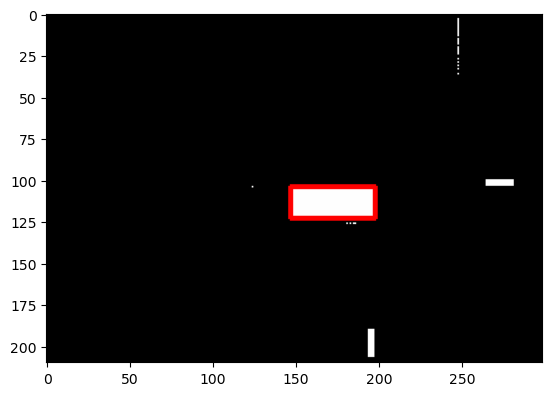

In [27]:
image = cv2.imread('/home/student/map_black.png')
# convert the image to grayscale format
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

iteration = 1
rooms_dict, iteration = room_detection(image,iteration) ## dictionary with all the rooms
masked_image = apply_mask(image,rooms_dict)

corridor_coordinates, iteration = room_detection(masked_image, iteration)
rooms_dict.update(corridor_coordinates)

In [28]:
def is_in_another_room(px, py, current_room, rooms_dict):
    for room, boundaries in rooms_dict.items(): 
        x = boundaries['x']
        y = boundaries['y']
        xw = boundaries['x+w']
        yh = boundaries['y+h']
        if room >= current_room:
            break
        if x <= px <= xw and y <= py <= yh and room != current_room:
            return True
    return False

In [29]:
def generate_snake_path(room_x, room_y, width, height, num_columns, num_rows, margin_percentage_width, margin_percentage_height):
    path = []

    # Calculate margins
    margin_x = width * margin_percentage_width
    margin_y = height * margin_percentage_height
    
    # Adjust the dimensions to account for margins
    adjusted_width = width - 2 * margin_x
    adjusted_height = height - 2 * margin_y

    # Calculate the actual width and height of each cell
    delta_x = adjusted_width / (num_columns -1)
    delta_y = adjusted_height / (num_rows - 1)

    y_start = room_y + margin_y  # Adjust starting y-coordinate within the room
    y = y_start
    direction = 1  # 1 means left to right, -1 means right to left
    count = 0

    for row in range(num_rows):
        if count >= num_columns * num_rows:
            break
        if direction == 1:
            x = room_x + margin_x  # Adjust starting x-coordinate within the room
            for col in range(num_columns):
                if count >= num_columns * num_rows:
                    break
                path.append((x, y))
                x += delta_x
                count += 1
        else:
            x = room_x + adjusted_width + margin_x  # Adjust starting x-coordinate within the room
            for col in range(num_columns):
                if count >= num_columns * num_rows:
                    break
                path.append((x, y))
                x -= delta_x
                count += 1

        y += delta_y
        direction *= -1  # Change direction

    return path


In [30]:
points_for_navigation = []
centers = []
for room, boundaries in rooms_dict.items(): 
    x = boundaries['x']
    y = boundaries['y']
    xw = boundaries['x+w']
    yh = boundaries['y+h']
    w = xw-x
    h = yh-y
    area = w*h
    if area > 150:
        centers.append((room, int(x+w*0.5), int(y+h*0.5)))
        # if area < 3000:
        #     rows = 2
        #     cols = 3
        #     perc = 0.15
        # elif 3000 <= area < 7000:
        #     rows = 5
        #     cols = 4
        #     perc = 0.08
        # elif 7000 <= area < 11000:
        #     rows = 6
        #     cols = 7
        #     perc  = 0.1
        # elif area >= 11000:
        #     rows = 7
        #     cols = 9
        #     perc = 0.05

        if area < 3000:
            rows = 2
            cols = 3
            perc = 0.15
        elif 3000 <= area < 7000:
            rows = 3
            cols = 2
            perc = 0.08
        elif 7000 <= area < 11000:
            rows = 4
            cols = 4
            perc  = 0.1
        elif area >= 11000:
            rows = 4
            cols = 6
            perc = 0.05

        snake_path = generate_snake_path(x, y, w, h, cols, rows, perc, perc)
        for point in snake_path:
            point_x, point_y = point
            points_for_navigation.append((room, int(point_x), int(point_y), 1))

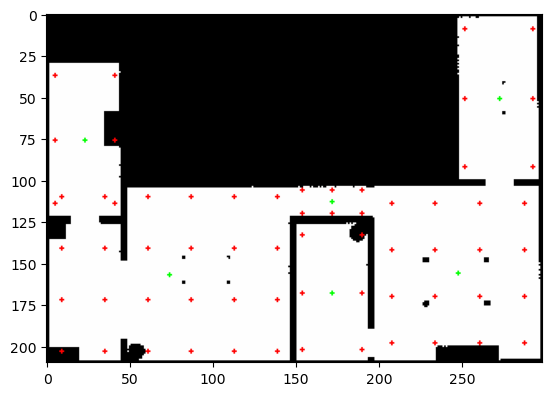

In [31]:
image_rgb = cv2.imread('/home/student/map_black.png')
for i in range(len(points_for_navigation)):
    image = cv2.circle(image_rgb, tuple(map(int, points_for_navigation[i][1:3])), radius=0, color=(255, 0, 0), thickness=2)
for i in range(len(centers)):
    image = cv2.circle(image_rgb, tuple(map(int, centers[i][1:3])), radius=0, color=(0, 255, 0), thickness=2)
plt.imshow(image)
plt.show
plt.savefig(f'grid_points.png', dpi=300)

In [32]:
import os
path_to_folder = os.getcwd();
path_to_points_file = path_to_folder + '/points_to_reach.txt'
path_to_centers_file = path_to_folder + '/centers.txt'
path_to_boxes_file = path_to_folder + '/boxes.txt'
# print(path_to_file)
with open(path_to_points_file, 'w') as f:
    for point in points_for_navigation:
        f.write(' '.join(map(str, point)) + '\n')
with open(path_to_centers_file, 'w') as f:
    for center in centers:
        f.write(' '.join(map(str, center)) + '\n')
with open(path_to_boxes_file, 'w') as f:
    for room, boundaries in rooms_dict.items(): 
        x = boundaries['x']
        y = boundaries['y']
        xw = boundaries['x+w']
        yh = boundaries['y+h']
        f.write(f'{room} {x} {y} {xw} {yh}\n')
